<a href="https://colab.research.google.com/github/tiara070403/seminar/blob/main/seminarfiks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn
!pip install Sastrawi
!pip install transformers
# Import Library
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import pipeline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('/content/crawling.csv', index_col=0)

In [ ]:
df = df[['created_at', 'full_text']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5349 entries, 1858070162362204643 to 1230765438897815552
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5349 non-null   object
 1   full_text   5349 non-null   object
dtypes: object(2)
memory usage: 125.4+ KB


In [ ]:
df['full_text'] = df['full_text'].replace('false', pd.NA)
df = df.dropna(subset=['full_text'])

In [ ]:
# Menghapus Duplikat
initial_duplicates = df.duplicated().sum()
df = df.drop_duplicates(subset=['full_text'])
print(f"Jumlah duplikat awal: {initial_duplicates}")
print(f"Jumlah duplikat setelah drop: {df.duplicated().sum()}")

Jumlah duplikat awal: 4
Jumlah duplikat setelah drop: 0


In [ ]:
# Menghapus baris dengan nilai null (setelah dropna subset)
print(f"Jumlah nilai null setelah dropna: \n{df.isnull().sum()}")

Jumlah nilai null setelah dropna: 
created_at    0
full_text     0
dtype: int64


In [ ]:
import pandas as pd

# 1) Buka file
df = pd.read_csv("crawling.csv")

# 2) Cek ukuran data & nama kolom
print("shape:", df.shape)
print("columns:", list(df.columns))

# 3) Lihat 5 baris teratas
df.head()

shape: (5349, 15)
columns: ['conversation_id_str', 'created_at', 'favorite_count', 'full_text', 'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 'user_id_str', 'username']


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1858070162362204643,Sun Nov 17 08:50:22 +0000 2024,2,lucu banget mahasiswa pencinta alam ini,1858070162362204643,NaN,NaN,in,NaN,0,1,0,https://x.com/undefined/status/185807016236220...,1716269490936360960,NaN
1,1846529554657239219,Wed Oct 16 12:32:07 +0000 2024,0,Bejat Mahasiswa Pencinta Alam di Jambi 'Genjot...,1846529554657239219,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/184652955465723...,2544978158,NaN
2,1467691301155979267,Wed Oct 09 13:58:44 +0000 2024,0,@Leonita_Lestari Ada Perkoempoelan Pentjinta A...,1844014639350452258,NaN,Leonita_Lestari,in,NaN,0,0,0,https://x.com/undefined/status/184401463935045...,1810821796767375360,NaN
3,1836014724523458593,Tue Sep 17 12:09:56 +0000 2024,0,[PRESS RELEASE SOWAN UKM KE UKM UNIT PANDU LIN...,1836014724523458593,https://pbs.twimg.com/media/GXrVp2Wa0AAv3zG.jpg,NaN,in,NaN,0,1,0,https://x.com/undefined/status/183601472452345...,297204645,NaN
4,1835164951125917967,Sun Sep 15 03:53:14 +0000 2024,0,[PRESS RELEASE SOWAN UKM KE UKM UNIT PANDU LIN...,1835164951125917967,https://pbs.twimg.com/media/GXfQzAtacAAlymL.jpg,NaN,in,NaN,0,1,0,https://x.com/undefined/status/183516495112591...,297204645,NaN


In [ ]:
# read 'full_text' column saja
df["full_text"].head()

,full_text
0,lucu banget mahasiswa pencinta alam ini
1,Bejat Mahasiswa Pencinta Alam di Jambi 'Genjot...
2,@Leonita_Lestari Ada Perkoempoelan Pentjinta A...
3,[PRESS RELEASE SOWAN UKM KE UKM UNIT PANDU LIN...
4,[PRESS RELEASE SOWAN UKM KE UKM UNIT PANDU LIN...


In [ ]:
!pip install tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

In [ ]:
import re
import pandas as pd

# load data
df = pd.read_csv("crawling.csv")

# load slang.csv (format: slang,formal)
slang_dict = pd.read_csv("slang.csv")
slang_map = dict(zip(slang_dict['slang'], slang_dict['formal']))

def preprocess_sentiment_no_stem(text):
      text = str(text).lower()                        # case folding
      text = re.sub(r'@\w+', ' ', text)               # hapus mention
      text = re.sub(r'http\S+|www.\S+', ' ', text)    # hapus URL
      text = re.sub(r'[^a-z\s]', ' ', text)           # hapus selain huruf
      text = re.sub(r'\s+', ' ', text).strip()        # rapikan spasi

      tokens = text.split()
      tokens = [slang_map.get(w, w) for w in tokens]  # normalisasi slang

      return " ".join(tokens)

# terapkan
df["clean_text"] = df["full_text"].apply(preprocess_sentiment_no_stem)

# simpan
# cek hasil
df[["full_text", "clean_text"]].head(10)
df[["full_text", "clean_text"]].to_csv("clean_crawling.csv", index=False)

print("✅ Selesai! Hasil disimpan di clean_crawling.csv")

✅ Selesai! Hasil disimpan di clean_crawling.csv


In [ ]:
df = pd.read_csv("/content/clean_crawling.csv")

In [ ]:
!pip install Sastrawi tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm.notebook import tqdm

# buat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

tqdm.pandas()

def stem_only(text):
      tokens = str(text).split()
      tokens = [stemmer.stem(w) for w in tokens]
      return " ".join(tokens)

# buat kolom baru hasil stemming
df["stemmed_text"] = df["clean_text"].progress_apply(stem_only)

# simpan hasil
df.to_csv("clean_crawling_stemmed.csv", index=False)

print("✅ Stemming selesai! Hasil ada di clean_crawling_stemmed.csv")


ERROR: Operation cancelled by user


  0%|          | 0/5349 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv("/content/clean_crawling_stemmed.csv")

In [ ]:
# Labeling
print("\nLabeling")
df = pd.read_csv('/content/clean_crawling_stemmed.csv')
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")
def prediksi_sentimen(teks):
    if not isinstance(teks, str) or not teks.strip():
        return 'neutral'
    try:
        hasil = classifier(teks)
        return hasil[0]['label']
    except Exception as e:
        print(f"Error predicting sentiment for text: '{teks[:50]}...' - {e}")
        return 'neutral'
print("\nMemulai proses Labeling")
df['sentimen'] = df['full_text'].apply(prediksi_sentimen)
print("Labeling selesai.")
df.to_csv('/content/labeling.csv', index=False)
print("\nDataframe dengan sentimen disimpan ke /content/labeling.csv")


Labeling


Device set to use cpu



Memulai proses Labeling
Labeling selesai.

Dataframe dengan sentimen disimpan ke /content/labeling.csv


In [ ]:
df = pd.read_csv("/content/labeling.csv")


In [ ]:
sentimen_counts = df.sentimen.value_counts()
print("\nDistribusi Sentimen:")
print(sentimen_counts)
print(f"\nFinal DataFrame Shape: {df.shape}")


Distribusi Sentimen:
sentimen
neutral     2720
positive    1620
negative    1009
Name: count, dtype: int64

Final DataFrame Shape: (5349, 4)



Visualisasi


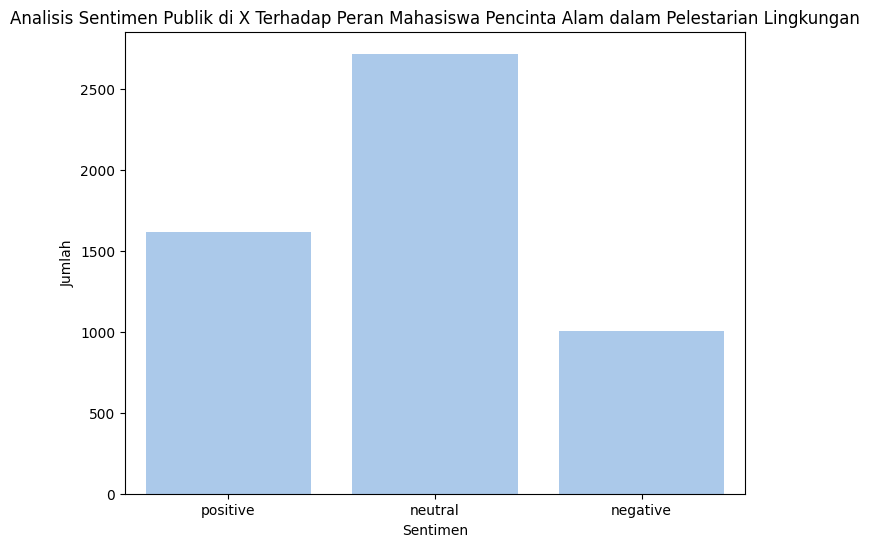

In [ ]:
# Visualisasi
print("\nVisualisasi")
sns.set_palette("pastel")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimen', data=df)
plt.title('Analisis Sentimen Publik di X Terhadap Peran Mahasiswa Pencinta Alam dalam Pelestarian Lingkungan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
data_positif = df[df['sentimen'] == 'positive']
data_negatif = df[df['sentimen'] == 'negative']
data_netral = df[df['sentimen'] == 'neutral']

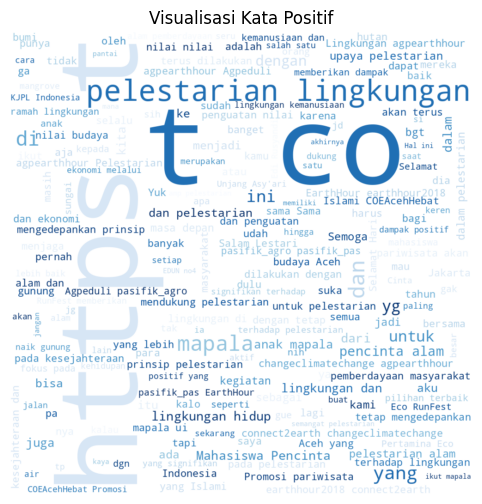

In [ ]:
# Word Cloud Positif
if not data_positif.empty:
    all_text_s1 = ' '.join(word for word in data_positif["full_text"].dropna())
    if all_text_s1:
        wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Visualisasi Kata Positif")
        plt.margins(x=0, y=0)
        plt.show()

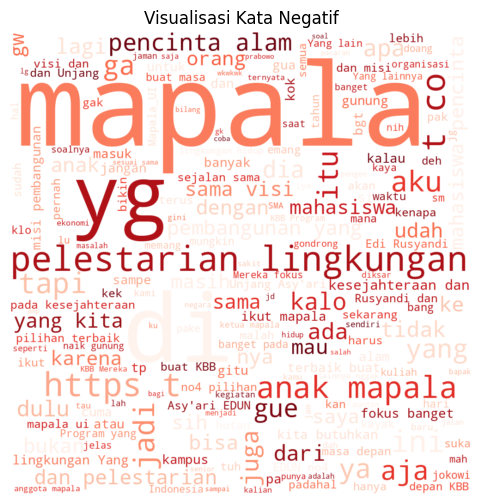

In [ ]:
# Word Cloud Negatif
if not data_negatif.empty:
    all_text_s0 = ' '.join(word for word in data_negatif["full_text"].dropna())
    if all_text_s0:
        wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Visualisasi Kata Negatif")
        plt.margins(x=0, y=0)
        plt.show()

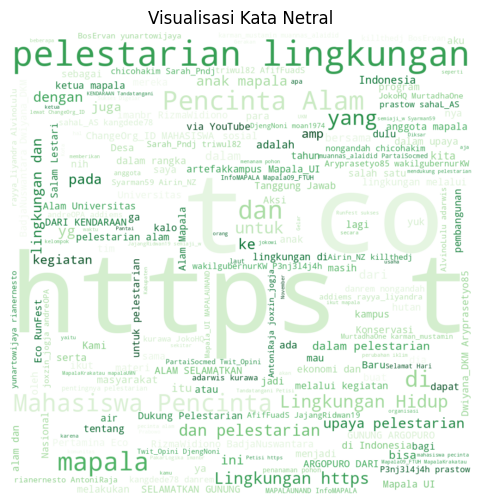

In [ ]:
# Word Cloud Netral
if not data_netral.empty:
    all_text_s2 = ' '.join(word for word in data_netral["full_text"].dropna())
    if all_text_s2:
        wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s2)
        plt.figure(figsize=(9, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Visualisasi Kata Netral")
        plt.margins(x=0, y=0)
        plt.show()

In [ ]:
# Split Data Train & Test
X = df['clean_text']
y = df['sentimen']

# Membagi data menjadi 80% training dan 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nJumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")
print(f"Proporsi label di training set:\n{y_train.value_counts(normalize=True)}")
print(f"Proporsi label di testing set:\n{y_test.value_counts(normalize=True)}")


Jumlah data training: 4279
Jumlah data testing: 1070
Proporsi label di training set:
sentimen
neutral     0.508530
positive    0.302875
negative    0.188595
Name: proportion, dtype: float64
Proporsi label di testing set:
sentimen
neutral     0.508411
positive    0.302804
negative    0.188785
Name: proportion, dtype: float64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Inisialisasi CountVectorizer
vectorizer = CountVectorizer()

# Fitur training diubah menjadi vektor frekuensi kata
X_train_vectorized = vectorizer.fit_transform(X_train)

# Fitur testing diubah menjadi vektor menggunakan vocabulary yang sama dari training set
X_test_vectorized = vectorizer.transform(X_test)

print(f"\nData training yang di-vektorisasi: {X_train_vectorized.shape}")
print(f"Data testing yang di-vektorisasi: {X_test_vectorized.shape}")


Data training yang di-vektorisasi: (4279, 12612)
Data testing yang di-vektorisasi: (1070, 12612)


In [ ]:
# Inisialisasi model Multinomial Naive Bayes
model = MultinomialNB()

# Melatih model
model.fit(X_train_vectorized, y_train)

print("\n--- Model Naive Bayes Berhasil Dilatih ---")


--- Model Naive Bayes Berhasil Dilatih ---



--- Hasil Evaluasi Model ---
Akurasi Model: 0.6589

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.46      0.78      0.58       202
     neutral       0.80      0.69      0.74       544
    positive       0.67      0.52      0.59       324

    accuracy                           0.66      1070
   macro avg       0.64      0.67      0.64      1070
weighted avg       0.70      0.66      0.66      1070


Confusion Matrix:
[[158  22  22]
 [106 377  61]
 [ 81  73 170]]


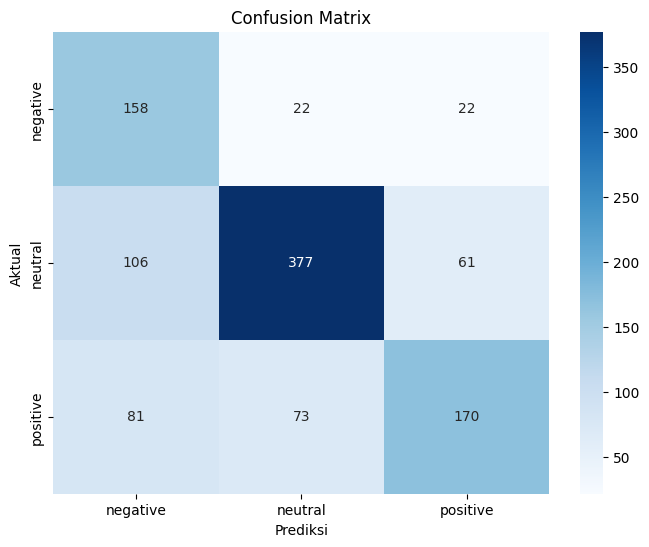


--- Contoh Prediksi Sentimen Baru ---
Teks: 'Mahasiswa pencinta alam sangat aktif dalam kegiatan reboisasi hutan, ini adalah langkah positif.'
Sentimen Prediksi: neutral

Teks: 'Beberapa kegiatan mahasiswa pencinta alam kurang berdampak nyata pada lingkungan, perlu perbaikan.'
Sentimen Prediksi: neutral

Teks: 'Inisiatif mereka untuk membersihkan sungai sangat menginspirasi dan patut dicontoh.'
Sentimen Prediksi: positive

Teks: 'Saya kecewa dengan kurangnya partisipasi dalam program daur ulang yang mereka adakan.'
Sentimen Prediksi: neutral



In [ ]:
# Melakukan prediksi pada data testing
y_pred = model.predict(X_test_vectorized)

# --- Evaluasi Model ---
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\n--- Hasil Evaluasi Model ---")
print(f"Akurasi Model: {accuracy:.4f}")
print("\nLaporan Klasifikasi:")
print(report)

print("\nConfusion Matrix:")
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

# --- Contoh Prediksi Baru ---
print("\n--- Contoh Prediksi Sentimen Baru ---")
new_texts = [
    "Mahasiswa pencinta alam sangat aktif dalam kegiatan reboisasi hutan, ini adalah langkah positif.",
    "Beberapa kegiatan mahasiswa pencinta alam kurang berdampak nyata pada lingkungan, perlu perbaikan.",
    "Inisiatif mereka untuk membersihkan sungai sangat menginspirasi dan patut dicontoh.",
    "Saya kecewa dengan kurangnya partisipasi dalam program daur ulang yang mereka adakan."
]

# Use the existing preprocessing function
clean_new_texts = [preprocess_sentiment_no_stem(text) for text in new_texts]
vectorized_new_texts = vectorizer.transform(clean_new_texts)
predictions = model.predict(vectorized_new_texts)

for i, text in enumerate(new_texts):
    # Map the predicted class to the sentiment label
    sentiment = predictions[i]
    print(f"Teks: '{text}'\nSentimen Prediksi: {sentiment}\n")